# 1. Функции

In [1]:
# Функция для расчета метрик
def metrics(y_true, y_predict):
  mae_score = MAE(y_true, y_predict)
  mse_score = MSE(y_true, y_predict)
  print('MAE = {}'.format(round(mae_score,2)))
  print('MSE = {}'.format(round(mse_score,2)))
  return mae_score, mse_score

In [2]:
# Визуализация соотношения y_true / y_predict на тесте

def true_predict_ratio(y_true, y_predict, xy_max):
    if xy_max == None:
        xy_max = max(y_true.max(), y_predict.max())
    plt.figure(figsize = (10,10))
    sns.scatterplot(x = y_true.values, y = y_predict)
    plt.title('Соотношение y_true / y_predict')
    plt.xlabel('y_true')
    plt.ylabel('y_predict')
    plt.xlim([-10, xy_max + 10])
    plt.ylim([-10, xy_max + 10])
    plt.savefig('pict.pdf', facecolor='w', edgecolor='b',
        orientation='portrait', bbox_inches='tight')

In [3]:
# Визуализация важности признаков

def importance_visualisation(model_fitted, cols):
  try:
    importances = pd.Series(data = abs(model_fitted.feature_importances_), index = list(cols))
  except:
    importances = pd.Series(data = abs(model_fitted.best_estimator_.feature_importances_), index = list(cols))

  importances = importances.sort_values(ascending = False)
  plt.figure(figsize = (10,4))
  sns.barplot(x = list(importances.index) , y = importances)
  plt.xticks(rotation = 90)
  plt.title('Значимость признаков')
  plt.show()

In [4]:
# Визуализация предсказаний для новых позиций
def true_predict_visual_uniq(y_true, y_predict, train_set):
  
  hues = list(train_set.columns)
  fig, ax = plt.subplots(len(hues), 1,  figsize=(6, 6 * len(hues)))
  ax_lim = np.array(list(y_true) + list(y_predict)).max()
  i = 0
  for i in range(len(hues)):
    if hues[i] == 'body':
      sns.scatterplot(x = y_true, y = y_predict, 
                    hue = train_set[hues[i]].replace(dict((v,k) for k, v in dict_body_num.items())).values, ax = ax[i])
    elif hues[i] == 'size':
      sns.scatterplot(x = y_true, y = y_predict, 
                    hue = train_set[hues[i]].replace(dict(zip((train_set['size'].unique()) , 
                                                          [str(value) for value in X['size'].unique()]))).values, ax = ax[i])
      
    else:
      sns.scatterplot(x = y_true, y = y_predict, hue = train_set[hues[i]].values, ax = ax[i])
    ax[i].set_title(hues[i])
    ax[i].set_xlabel('y_true_test')
    ax[i].set_ylabel('y_predict_test')
    ax[i].set_xlim([-50, ax_lim + 50])
    ax[i].set_ylim([-50, ax_lim + 50])  

# 1. Загрузка и предварительный анализ данных

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid') #, {'grid.color': '.1', 'text.color': '.1', 'text.size' : '40'})
sns.set(font_scale=1)
import plotly.express as px

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as MAE , mean_squared_error as MSE, make_scorer
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.externals import joblib

import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import timeit

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Загружаем данные

In [6]:
total_spec = pd.read_excel('spec_work.xlsx', index_col = 0)
total_spec

,valve_type,size,class_rating,body,connection,actuator,trim,seat,face_to_face,weight,specification,usd_unit_price
0,GLOBE VALVE TO API623,150,300,A352 LCC,FLANGED,H / L,316_HF,METAL,445,173.0,ner_ggc,1857.16
1,GATE VALVE,20,600,A182 F316,FLANGED,H / L,316_HF,METAL,191,5.6,kfap,192.00
2,GLOBE VALVE,50,150,A350 LF2,FLANGED,H / L,316_HF,METAL,203,21.0,kfap,146.00
3,GATE VALVE,25,300,A182 F316,FLANGED,H / L,316_HF,METAL,165,12.5,kfap,208.00
4,SWING CHECK VALVE,80,300,A216 WCB,FLANGED,NO,316_HF,METAL,318,40.0,kfap,195.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1657,SWING CHECK VALVE,150,300,A216 WCB,FLANGED,NO,316_HF,METAL,445,118.0,kfap,497.00
1658,SWING CHECK VALVE,80,300,A216 WCB,FLANGED,NO,316_HF,METAL,318,40.0,kfap,195.00
1659,GLOBE VALVE,150,300,A216 WCB,FLANGED,H / L,316_HF,METAL,445,173.0,kfap,863.00
1660,GLOBE VALVE,80,150,A216 WCB,FLANGED,H / L,316_HF,METAL,241,35.0,kfap,243.00


# 2. EDA анализ - подготовка

Некоторые материалы являются аналогами (отличаются технологией получения - литье или поковка). Можем их объединить

In [7]:
dict_body = {
    'A216 WCB' : 'WCB',
    'A350 LF2' : 'LF2_LCB_LCC', 'A352 LCC' : 'LF2_LCB_LCC', 'A352 LCB' : 'LF2_LCB_LCC',


    'A182 F11' : 'F11_WC6', 'A217 WC6' : 'F11_WC6', 
    'A182 F9' : 'F9_C12', 'A217 C12' : 'F9_C12',
    'A182 F316' : 'F316_CF8M', 'A351 CF8M' : 'F316_CF8M',
    'A182 F321' : 'F321',
    'A182 F347' : 'F347_CF8C', 'A351 CF8C' : 'F347_CF8C',
    'ASTM A351 CF8' : 'F304_CF8', 'ASTM A182 F304/304L' : 'F304_CF8'
}

In [8]:
total_spec['body'] = total_spec['body'].replace(dict_body)

# 3. Подготовка данных для обучения моделей

## 3.1 Первым делом стоит перевести body в численный тип данных. Т.к. есть понимание какой материал дороже а какой дешевле. Для наглядности создадим новый числовой столбец и сохраним старый категориальный а потом посмотрим на важность признаков в моделях

# Источник, по которому подобраны коэффициенты для материалов корпуса  
https://ru.scribd.com/doc/237305322/Material-Reference-Chart

In [9]:
dict_body_num = {
    'A216 WCB' : 3, 'WCB' : 3,
    'A350 LF2' : 4, 'A352 LCC' : 4, 'A352 LCB' : 4, 'LF2_LCB_LCC' : 4,
    'A182 F11' : 5, 'A217 WC6' : 5,  'F11_WC6' : 5,
    'A182 F9' : 6, 'A217 C12' : 6, 'F9_C12' : 6,
    'F304_CF8' : 8,
    'A182 F316' : 9, 'A351 CF8M' : 9, 'F316_CF8M' : 9,
    'A182 F321' : 10, 'F321' : 10,
    'A182 F347' : 11, 'A351 CF8C' : 11, 'F347_CF8C' : 11,
    
    'A351 CK3MCuN': 14,
    'UNS S32205': 14,

    'B381 F2' : 140
}

In [10]:
total_spec['body_num'] = total_spec['body'].replace(dict_body_num)

total_spec = total_spec.loc[:, ['valve_type', 'size', 'class_rating', 'body', 'connection', 'actuator',
       'trim', 'seat', 'face_to_face', 'weight', 'specification', 'body_num',
       'usd_unit_price']]

## 3.2 Отделение целевого признака. Выделение количественных и категориальных признаков

In [11]:
X = total_spec.drop(columns = ['usd_unit_price'])
y = total_spec['usd_unit_price']

In [12]:
num_features = list(X.columns[[col != 'object' for col in X.dtypes]])
cat_features = list(X.columns[[col == 'object' for col in X.dtypes]])

Дальше будет следующая последовательность:  
1. Обработка категориальных признаков, потому что если сначала сделать разделение на обучающую и тестовую выборки то есть риск что не все варианты категориальных признаков попадут в каждую из выборок.  
2. Разделение на обучающую и тестовую выборки.  
3. Нормализация числовых признаках - тут уже нужно отдельно обрабатывать обучающую и тестовую выборки

## 3.4  ordinal преобразованные данные:

In [13]:
encoder = OrdinalEncoder()

X_ord = X.copy()
encoder.fit(X_ord[cat_features])

X_ord[cat_features] = X_ord[cat_features].fillna("nan_value")
X_ord[cat_features] = pd.DataFrame(encoder.transform(X_ord[cat_features]), columns = cat_features)
X_ord[cat_features] = X_ord[cat_features].astype(int)

In [14]:
X_ord.body.unique()

array([6, 3, 8, 1, 0, 2, 5, 4, 7])

In [15]:
print('Введите количество моделей')
n_models = int(input())

Введите количество моделей
25


In [16]:
rand_best_params_list = []
for i in range(n_models):
    ## 3.5 Разделение на train и eval
    total_spec_train, total_spec_eval, \
    X_train, X_eval,  \
    X_ord_train, X_ord_eval,  \
    y_train, y_eval = train_test_split(total_spec , X, X_ord, y, test_size = 0.1, shuffle=True) 
    ## 3.7 Стандартизация
    scaler = StandardScaler()

    X_st_train = X_train.copy()
    X_st = X.copy()
    X_st_eval = X_eval.copy()
    X_st_train[num_features] = scaler.fit_transform(X_st_train[num_features])
    X_st[num_features] = scaler.transform(X_st[num_features])
    X_st_eval[num_features] = scaler.transform(X_st_eval[num_features])

    X_ord_st_train = X_ord_train.copy()
    X_ord_st = X_ord.copy()
    X_ord_st_eval = X_ord_eval.copy()
    X_ord_st_train[num_features] = scaler.fit_transform(X_ord_st_train[num_features])
    X_ord_st[num_features] = scaler.transform(X_ord_st[num_features])
    X_ord_st_eval[num_features] = scaler.transform(X_ord_st_eval[num_features])
    
    ## 5.1 lgbm + gridsearch + default score
    
#     pg_grid = {'boosting_type' : ['gbdt'],
#             'num_leaves': [8,10,12],
#             'max_depth':  [7,8,9] ,
#             'n_estimators' : [200, 400, 800],
#             'min_data_in_leaf': [2, 3]}
#             # 'number_iterations' : [10,50,100],
#             # 'function_fraction' : [0.8, 1],
#             # 'bagging_fraction' : [0.8, 1]}
            
    pg_random_search = {'boosting_type' : ['gbdt'],
            'num_leaves': list(range(4,21,2)),
            'max_depth':  list(range(7,13,1)),
             'n_estimators' : [200, 500, 800, 1000],
                  'min_data_in_leaf': list(range(1,8,1))}

    # Задаем модель
#     model_lgbm1 = GridSearchCV(estimator = LGBMRegressor( objective= 'mse', verbose = 10),
#                            param_grid= pg_LGBM1, cv=3, n_jobs=-1 , verbose=10, scoring = 'neg_mean_squared_error')
    
    
    model = RandomizedSearchCV(estimator= LGBMRegressor( objective= 'regression', verbose = 50), scoring = 'neg_mean_squared_error', 
                               param_distributions= pg_random_search, 
                               n_iter = 100, n_jobs=-1, verbose = 50, cv = 3)
    
     # Обучаем модель
    model.fit(X_ord_st, y, categorical_feature = cat_features)
    rand_best_params_list.append(list(model.best_params_.values()) + [(model.best_score_)])
    print('Результаты по модели №',i)
    print(model.best_params_)
    
    # сохраняем модель    
    joblib.dump(model.best_estimator_, 'models_fitted/model_fitted_{}.pkl'.format(i))   

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:   40.9s
[Paralle

[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:  1.4min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 0
{'num_leaves': 6, 'n_estimators': 800, 'min_data_in_leaf': 2, 'max_depth': 7, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapse

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   38.0s
[Paralle

[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.2min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 1
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 3, 'max_depth': 8, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elaps

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   33.8s
[Paralle

[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.1min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 2
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 1, 'max_depth': 11, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elap

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  1.2min
[Paralle

[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  2.2min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 3
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 3, 'max_depth': 11, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elap

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   39.8s
[Paralle

[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.3min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 4
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 1, 'max_depth': 8, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elaps

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   33.1s
[Paralle

[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.1min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 5
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 1, 'max_depth': 10, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1925s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 

[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.4s
[Paralle

[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 286 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 287 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:  1.3min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 6
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 4, 'max_depth': 9, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elaps

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   40.8s
[Paralle

[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.2min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 7
{'num_leaves': 4, 'n_estimators': 800, 'min_data_in_leaf': 1, 'max_depth': 12, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elaps

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   30.5s
[Paralle

[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.2min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 8
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 1, 'max_depth': 10, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elap

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:   37.5s
[Paralle

[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:  1.1min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 9
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 1, 'max_depth': 12, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elap

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   33.8s
[Paralle

[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.2min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 10
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 1, 'max_depth': 10, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | ela

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   38.6s
[Paralle

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  1.2min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 11
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 3, 'max_depth': 12, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | ela

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   34.0s
[Paralle

[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.2min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 12
{'num_leaves': 4, 'n_estimators': 800, 'min_data_in_leaf': 1, 'max_depth': 8, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elaps

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   39.9s
[Paralle

[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.2min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 13
{'num_leaves': 4, 'n_estimators': 800, 'min_data_in_leaf': 1, 'max_depth': 10, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elap

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   40.3s
[Paralle

[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.3min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 14
{'num_leaves': 4, 'n_estimators': 800, 'min_data_in_leaf': 4, 'max_depth': 12, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elap

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   30.6s
[Paralle

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 15
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 3, 'max_depth': 7, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elap

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   34.6s
[Paralle

[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.1min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 16
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 1, 'max_depth': 9, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elap

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   29.9s
[Paralle

[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.4min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 17
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 4, 'max_depth': 12, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | ela

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   33.3s
[Paralle

[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.1min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 18
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 1, 'max_depth': 10, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | ela

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   34.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:   59.5s
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 19
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 3, 'max_depth': 10, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | ela

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:   36.1s
[Paralle

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 20
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 3, 'max_depth': 7, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elap

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   32.6s
[Paralle

[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.0min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 21
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 3, 'max_depth': 12, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | ela

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   37.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.1min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 22
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 1, 'max_depth': 11, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | ela

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:   31.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 283 tasks      | elapsed:  1.0min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 23
{'num_leaves': 4, 'n_estimators': 800, 'min_data_in_leaf': 1, 'max_depth': 9, 'boosting_type': 'gbdt'}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elaps

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   34.4s
[Paralle

[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  1.0min
[Paralle

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['actuator', 'body', 'connection', 'seat', 'specification', 'trim', 'valve_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Результаты по модели № 24
{'num_leaves': 4, 'n_estimators': 1000, 'min_data_in_leaf': 3, 'max_depth': 10, 'boosting_type': 'gbdt'}


In [17]:
print('А теперь введите количество моделей, которые будем брать для СРЕДНЕГО предсказания')
n_models_pred = int(input())

А теперь введите количество моделей, которые будем брать для СРЕДНЕГО предсказания
25


In [18]:
list_models = []
for i in range(n_models_pred):
    list_models.append(joblib.load('models_fitted/model_fitted_{}.pkl'.format(i)))        

In [19]:
def model_mean(list_of_models, X):
    pred = np.zeros(len(X))
    for model in list_of_models:
        pred += model.predict(X)
    pred = pred / len(list_of_models)
    return pred

# Теперь загружаем и предобрабатываем тестовый датасет

In [20]:
test_set = pd.read_excel('spec_test.xlsx', index_col = 0)

X_test = test_set[['valve_type', 'size', 'class_rating', 'body', 'connection', 'actuator',
       'trim', 'seat', 'face_to_face', 'weight', 'specification']]

In [21]:
X_test['body'] = X_test['body'].replace(dict_body)
X_test['body_num'] = X_test['body'].replace(dict_body_num)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
## 3.7 Ordinalencoder
X_test_ord = X_test.copy()
X_test_ord[cat_features] = X_test_ord[cat_features].fillna("nan_value")
X_test_ord[cat_features] = pd.DataFrame(encoder.transform(X_test_ord[cat_features]), columns = cat_features)
X_test_ord[cat_features] = X_test_ord[cat_features].astype(int)
## 3.7 Стандартизация
X_test_ord_st = X_test_ord.copy()
X_test_ord_st[num_features] = scaler.transform(X_test_ord_st[num_features])

In [23]:
test_set['predict_price'] = model_mean(list_models, X_test_ord_st)
test_set['delta_usd'] = test_set['usd_unit_price'] - test_set['predict_price']

def mape(y_true, y_predict):
  return 100. * (y_true - y_predict) / y_true

test_set['mape'] = mape(test_set['usd_unit_price'], test_set['predict_price'] )

In [24]:
test_set.to_excel('results.xlsx')

метрики на тестовой выборке:
MAE = 36.9
MSE = 10305.69


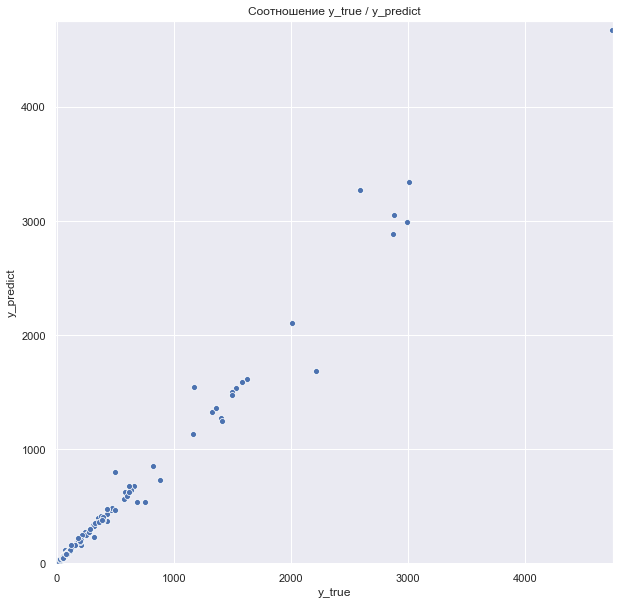

In [25]:
print('метрики на тестовой выборке:')
metrics(test_set['usd_unit_price'],  model_mean(list_models, X_test_ord_st))
true_predict_ratio(test_set['usd_unit_price'],  model.predict(X_test_ord_st), None)

In [26]:
print('Расчет закончен. Предсказанные цены и график можно посмотреть в файлах results.xlsx и pict.pdf')

Расчет закончен. Предсказанные цены и график можно посмотреть в файлах results.xlsx и pict.pdf
